## O2-O2- and O2-N2 theoretical CIA model reported by Karman et al

Karman et al published a theoretical O_2 - O_2 and O_2 - N_2 collision-induced absorption model based on quantum calculations <https://doi.org/10.1038/s41557-018-0015-x>.  This model is composed of spin-orbit and exchange mechanisms.  In the manuscript Parameterized Model to Approximate Theoretical Collision-Induced Absorption Band Shapes for O2-O2 and O2-N2, Adkins et al present a parameterized representation of the theoretical model reported by Karman et al. 

We have included this parameterized model in MATS to allow for use in multi-spectrum fitting analyses in order to fit monomer and CIA components to the absorption.


In [1]:
import numpy as np
import pandas as pd
import qgrid
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


import MATS

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")

HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

Most of this example follows from the theoretical spectra generation and fit example.  However, this example makes use of the new Karman et al parameterized CIA. 

In the first step we read in the linelist.  The one used in the example is that reported in the JQSRT 270 (2021) 107684.  However this linelist is for demonstration purposes only, users should refer to that paper for the actual line list.  

In [2]:
from MATS.linelistdata import linelistdata
PARAM_LINELIST = linelistdata['Singlet_Delta_Linelist_JQSRT_270_2021_107684']
PARAM_LINELIST.sort_values('nu', inplace = True)



In this example, we have written a definition that simulates the monomer absorption for a spectrum, simulates a theoretical CIA based on the Karman et al model using the o2_cia_karman_model definition, and then adds the theoretical cia to the simulated monomer absorption in the spectrum alpha data.  

The os_cia_karman_model function requires wavenumber axis, temperature, pressure, and sample composition (O2 and N2 only), in addition to values for the Spin_orbit magnitude for both O2-O2 and O2-N2, exchange magnitude of O2-O2, temperature dependences for spin orbit (O2-O2 and O2-N2, can be constrained later to be equal) and exchange intensities.  Additionally, the band being studied a_band or singlet_delta needs to be specified.   

c:\users\ema3\mats\MATS\spectrum.py:149: RuntimeWarning: divide by zero encountered in reciprocal
  self.tau = (self.alpha*CONSTANTS['c'] / 1e12)**-1
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


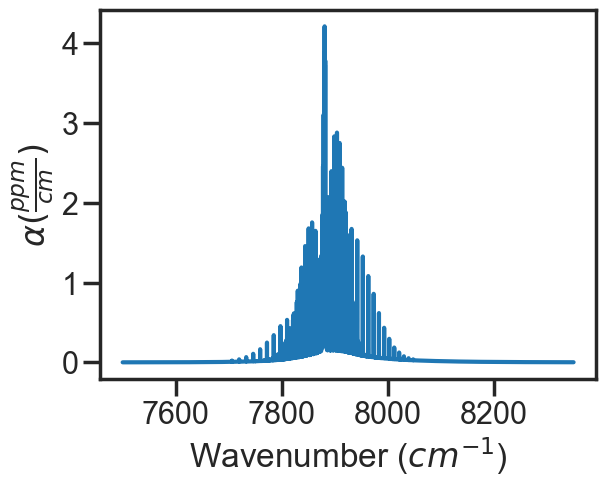

In [3]:
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-20 #intensities must be above this value for the line to be fit
order_baseline_fit = 0


wave_min = 7500 #cm-1
wave_max = 8350 #cm-1
wave_space = 0.01 #cm-1
wavenumbers = np.arange(wave_min, wave_max, 0.02)


def sim_spectra_with_CIA(pressure, temperature, sample_molefraction, filename):
    Diluent = {'O2': {'composition':sample_molefraction[7], 'm': 31.998}, 'N2': {'composition':1-sample_molefraction[7], 'm': 28.0134}}
    spec =  MATS.simulate_spectrum(PARAM_LINELIST, wavenumbers = wavenumbers, 
                         temperature = temperature,  pressure = pressure,
                         molefraction = sample_molefraction, Diluent = Diluent,
                         filename = filename, wing_wavenumbers = 25, wing_method = 'wing_wavenumbers',)
    # Adjusted from Initial guess derived based HITRAN 2020 reported theoretical CIA
    EXCH_c, EXCH_b, EXCH_a = [3.63e-06, 0.003, 1]
    SO_c, SO_b, SO_a =[1.5e-06, 0.0002, 1]
    SO_O2, SO_N2, EXCH_O2 = [40, 75 ,315] 

    CIA = MATS.o2_cia_karman_model(wavenumbers, temperature + 273.15, pressure/760, Diluent,
                            SO_O2, SO_N2, EXCH_O2, 
                            EXCH_b, EXCH_c, #O2-O2
                            SO_b, SO_c, #O2-N2
                            SO_b, SO_c, 
                            SO_shift_O2_O2 = 0, SO_shift_O2_N2 = 0, EXCH_shift = 0,
                            band = 'singlet_delta')
    spec.alpha += CIA
    return spec

spec_1 = sim_spectra_with_CIA(760, 22.85, {7 :0.2095}, 'Air_296')
spec_2 = sim_spectra_with_CIA(760, 0, {7 :0.2095}, 'Air_273')
spec_3 = sim_spectra_with_CIA(760, 50, {7 :0.2095}, 'Air_323')
spec_4 = sim_spectra_with_CIA(760, 22.85, {7 :1}, 'O2_296')
spec_5 = sim_spectra_with_CIA(760, 0, {7 :1}, 'O2_273')
spec_6 = sim_spectra_with_CIA(760, 50, {7 :1}, 'O2_323')


spec_1.plot_wave_alpha()

The CIA model is specified in the instantiation of the Dataset class.  The CIA_model is specified through a dictionary specifying both the model and band.  Currently, the Karman model is the only model available and the available bands are a_band and singlet_delta.  

Like the generate_baseline_paramlist() definition, the generate_CIA_paramlist() generates a dataframe and file that summarizes the parameters based on the MATS preset values from the literature.  https://doi.org/10.1038/s41557-018-0015-x, https://doi.org/10.1016/j.icarus.2019.02.034

In [4]:
#Add all spectrum to a Dataset object
SPECTRA = MATS.Dataset([spec_1, spec_2, spec_3, spec_4, spec_5, spec_6], 
                       'Experimental Singlet Delta with CIA', PARAM_LINELIST, CIA_model = {'model':'Karman', 'band': 'singlet_delta'})

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
CIA_LINELIST = SPECTRA.generate_CIA_paramlist()
CIA_LINELIST

,CIA Pair,S_SO,S_EXCH,EXCH_b,EXCH_c,SO_b,SO_c,SO_shift,EXCH_shift
0,O2_O2,39.13,304.744817,0.002839,0.000004,0.000146,0.000001,0,0
1,O2_N2,70.74,0.000000,0.000000,0.000000,0.000146,0.000001,0,0


In the Generate_FitParam_File class, the CIA_linelist is set to the CIA_LINELIST generated by the generate_CIA_paramlist.  The genererate_fit_KarmanCIA_linelist() will then add the uncertainty and boolean vary columns, setting the vary column to vary the parameters indicated in the definition call.

In [5]:
FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, CIA_linelist = CIA_LINELIST, 
                                        lineprofile = 'SDNGP', linemixing = True, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:False, 2:False, 3:False}}, vary_sw = {7:{1:False, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:False}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:False}}, 
                                                    vary_aw = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = False, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= False, vary_etalon_period= False, vary_etalon_phase= False, 
                                         vary_pressure = False, vary_temperature = False)
FITPARAMS.generate_fit_KarmanCIA_linelist(vary_S_SO = True, vary_S_EXCH = True, 
                                        vary_EXCH_temp = True, vary_SO_temp = True, 
                                        vary_EXCH_shift = False, vary_SO_shift = False)

,CIA Pair,S_SO,S_SO_err,S_SO_vary,S_EXCH,S_EXCH_err,S_EXCH_vary,EXCH_b,EXCH_b_err,EXCH_b_vary,...,SO_b_vary,SO_c,SO_c_err,SO_c_vary,SO_shift,SO_shift_err,SO_shift_vary,EXCH_shift,EXCH_shift_err,EXCH_shift_vary
0,O2_O2,39.13,0,True,304.744817,0,True,0.002839,0,True,...,True,0.000001,0,True,0,0,False,0,0,False
1,O2_N2,70.74,0,True,0.000000,0,True,0.000000,0,True,...,True,0.000001,0,True,0,0,False,0,0,False


Finally, in the Fit_Dataset instance, the CIA_linelist_file needs to be specified to indicate what parameters are being adjusted, provide initial values, and to allow uncertainties to be updated.  

The CIA parameters can be constrained using the constrained_CIA parameters() definition.  The default option is that the the spin orbit intensity temperature dependence is the same for O2-O2 and O2-N2.  Additionally, the shift of the spin-orbit mechanism is normally constrained to be the same for O2-O2 and O2-N2.  However, either of these constraints can be removed by setting  S_temperature_dependence_constrained = False or shift_constrained = False.  

The rest of the fitting runs in the same manner as for monomer-absorption only MATS fits.  

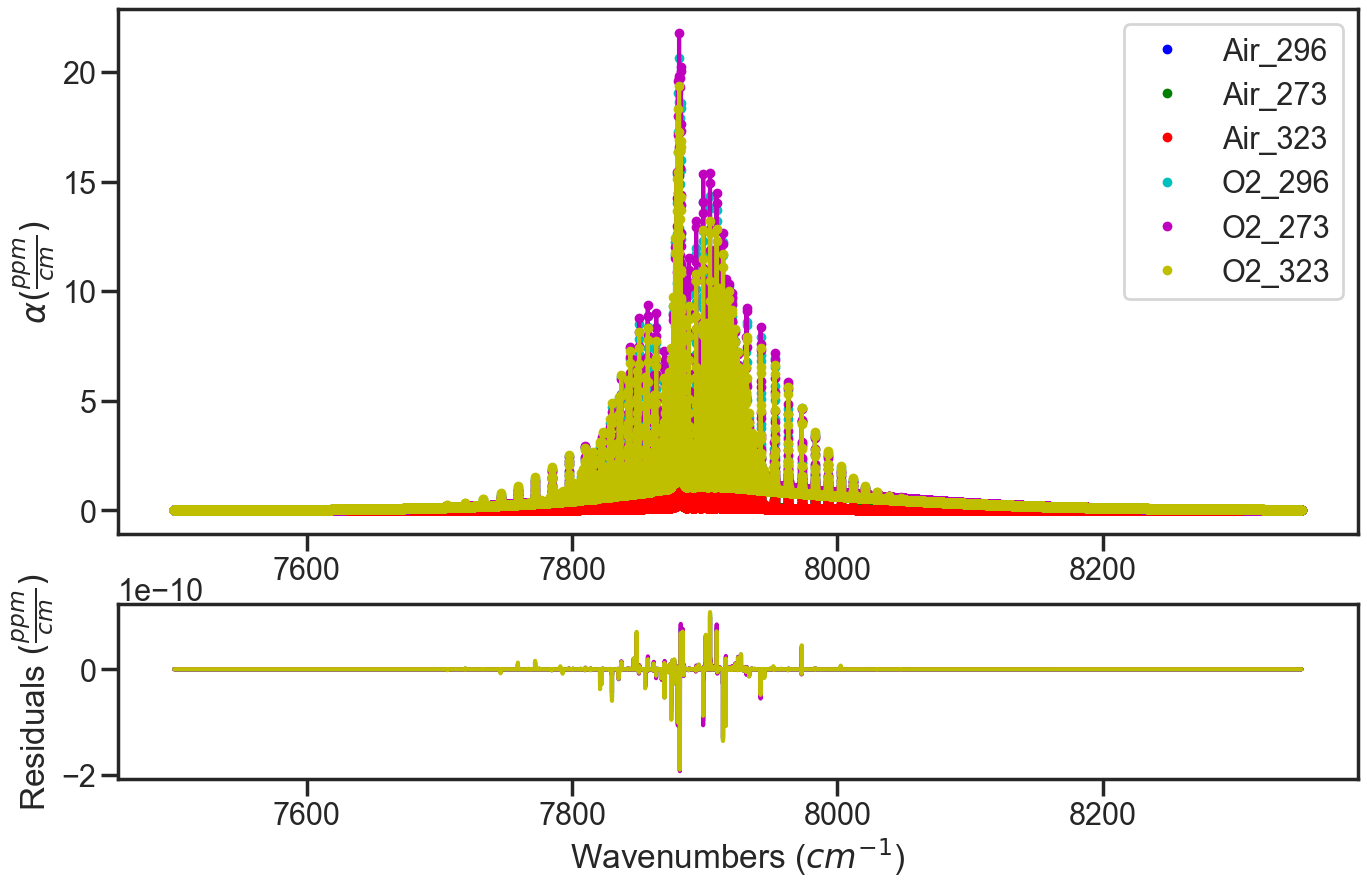

In [6]:
fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', CIA_linelist_file = 'CIA_LineList',
                            minimum_parameter_fit_intensity = Fit_Intensity)
params = fit_data.generate_params()
params = fit_data.constrained_CIA(params)
for param in params:
    if 'S_SO' in param:
        params[param].set(min = 0.00)
    if 'S_EXCH' in param:
        params[param].set(min = 0.00)

result = fit_data.fit_data(params, wing_wavenumbers = 25,  wing_method = 'wing_wavenumbers')
fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()



In [7]:
result.params

C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in longlong_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in true_divide
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))


name,value,standard error,relative error,initial value,min,max,vary,expression
Pressure_1_0,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False,
Temperature_1_0,296.000000,0.00000000,(0.00%),295.9999999999841,-inf,inf,False,
x_shift_1_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
molefraction_O2_1_0,0.20950000,0.00000000,(0.00%),0.2095,-inf,inf,False,
molefraction_H2O_1_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
baseline_a_1_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
Pressure_2_0,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False,
Temperature_2_0,273.150000,0.00000000,(0.00%),273.15000000000003,-inf,inf,False,
x_shift_2_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
molefraction_O2_2_0,0.20950000,0.00000000,(0.00%),0.2095,-inf,inf,False,
